## This study follows the deployment framework of [1] and uses the Lycos-IDS2017 dataset of [2]

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
path = os.getcwd()

In [3]:
attack = pd.read_csv(f'{path}/data/Friday-WorkingHours.pcap_lycos.csv')

In [4]:
attack.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,192.168.10.3-192.168.10.50-3268-56108-6,192.168.10.3,3268,192.168.10.50,56108,6,1499428790315195,112740690,2.0,403.0,0.0,158.333333,31450.099291,177.341758,67.411331,0.425756,0.141919,0.283837,16,1152,72.0,0.0,72.0,0.000000,512,32,16,32,6448,403.0,0.0,201.5,204.724205,1024,32,16,16399772.0,3.0,2.398738e+06,5.798698e+06,112740348,16400110.0,3.0,7.516023e+06,8.323385e+06,112740690,16399772.0,3.0,3.636796e+06,6.848761e+06,380.0,343.0,3.594286e+02,1.199802e+01,16399772.0,15375229.0,1.610540e+07,4.988048e+05,0,0,0,48,32,16,16,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,144.000000,2.000000,806.000000,4.000000,2078,377,benign
1,192.168.10.50-192.168.10.3-42144-389-6,192.168.10.50,42144,192.168.10.3,389,6,1499428790316273,112740560,0.5,403.0,0.0,239.666667,30619.460993,174.984174,102.039585,0.425756,0.283838,0.141919,32,6448,403.0,0.0,201.5,204.724205,1024,32,16,16,5056,316.0,0.0,316.0,0.000000,512,32,16,16399782.0,2.0,2.398735e+06,5.798710e+06,112740560,16399782.0,2.0,3.636792e+06,6.848777e+06,112740242,16400110.0,4.0,7.516016e+06,8.323376e+06,330.0,285.0,3.202857e+02,1.574499e+01,16399782.0,15375263.0,1.610543e+07,4.987937e+05,0,0,0,48,32,16,16,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,806.000000,4.000000,632.000000,2.000000,955,2078,benign
2,192.168.10.9-224.0.0.22-0-0-2,192.168.10.9,0,224.0.0.22,0,2,1499428834843793,54760,0.0,8.0,8.0,8.000000,0.000000,0.000000,584.368152,73.046019,73.046019,0.000000,4,32,8.0,8.0,8.0,0.000000,32,8,4,0,0,0.0,0.0,0.0,0.000000,0,0,0,53431.0,108.0,1.825333e+04,3.046984e+04,54760,53431.0,108.0,1.825333e+04,3.046984e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,32.0,4.0,584.368152,0.0,0.0,0.0,32.000000,4.000000,0.000000,0.000000,-1,-1,benign
3,192.168.10.9-224.0.0.252-63210-5355-17,192.168.10.9,63210,224.0.0.252,5355,17,1499428834845380,100126,0.0,28.0,28.0,28.000000,0.000000,0.000000,6152.248167,219.723149,219.723149,0.000000,22,616,28.0,28.0,28.0,0.000000,176,8,22,0,0,0.0,0.0,0.0,0.000000,0,0,0,100055.0,1.0,4.767905e+03,2.183302e+04,100126,100055.0,1.0,4.767905e+03,2.183302e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,616.0,22.0,6152.248167,0.0,0.0,0.0,616.000000,22.000000,0.000000,0.000000,-1,-1,benign
4,192.168.10.9-192.168.10.3-137-137-17,192.168.10.9,137,192.168.10.3,137,17,1499428835164943,93069427,1.0,68.0,50.0,59.000000,46.153846,6.793662,25.357414,0.429787,0.214893,0.214893,20,1180,68.0,50.0,59.0,9.233805,160,8,20,20,1180,62.0,0.0,59.0,3.077935,160,8,20,50763066.0,3.0,2.386396e+06,9.205496e+06,93069292,50763154.0,3.0,4.898384e+06,1.288064e+07,93069201,50763201.0,3.0,4.898379e+06,1.288065e+07,11894792.0,1512212.0,6.703502e+06,7.341593e+06,50763066.0,28899219.0,3.983114e+07,1.546007e+07,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,

In [5]:
attack['label'].unique()

array(['benign', 'bot', 'portscan', 'ddos'], dtype=object)

In [6]:
attack['ip_prot'].unique()

array([  6,   2,  17,   1, 132])

In [7]:
df=attack

In [8]:
df.describe()

,src_port,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes
count,542962.000000,542962.000000,542962.000000,5.429620e+05,5.429620e+05,542962.000000,542962.000000,542962.000000,542962.000000,5.429620e+05,542962.000000,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,542962.000000,542962.000000,542962.000000,542962.000000,542962.000000,542962.000000,5.429620e+05,542962.000000,542962.000000,542962.000000,5.429620e+05,542962.000000,542962.000000,542962.000000,542962.000000,5.429620e+05,542962.000000,542962.000000,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,5.429620e+05,542962.000000,542962.000000,542962.000000,542962.000000,542962.000000,542962.000000,542962.000000,542962.0,542962.0,542962.0,542962.000000,542962.000000,542962.000000,542962.000000,5.429620e+05,5.429620e+05,542962.000000,5.429620e+05,542962.000000,542962.000000,5.429620e+05,542962.000000,542962.000000,542962.000000
mean,47329.304095,2759.894764,9.840136,1.499447e+15,8.122517e+06,1.088947,1588.334033,15.170905,330.905652,1.512636e+06,580.146614,3.760703e+05,2.340645e+04,1.279163e+04,1.061482e+04,7.595075,365.201025,123.633816,15.294455,35.491913,36.926209,1.729564e+02,20.199196,1.953245,9.189205,1.415033e+04,1561.305259,0.139155,526.502606,670.200805,2.027072e+02,16.676327,7.402148,3.036891e+06,1.027556e+04,5.545823e+05,1.113809e+06,7.795783e+06,2.823622e+06,7.458039e+05,1.245869e+06,7.864710e+05,7.484279e+06,2.594359e+06,8.423952e+05,1.313305e+06,6.648233e+05,1.175370e+05,3.746564e+04,5.514996e+04,3.371825e+04,2.594182e+06,2.409043e+06,2.516354e+06,1.054790e+05,0.991561,0.328093,0.301132,14.808834,2.174681,0.976264,1.198417,0.0,0.0,0.0,0.000350,0.000326,51.564557,0.169683,1.346116e+05,2.663350e+03,1.288817,1.269580e+06,161.612610,4.605144,9.045134e+03,5.616333,9206.506675,9693.412156
std,15810.672737,8543.048233,5.401070,7.900628e+09,2.615344e+07,0.379000,2903.036685,24.602741,540.475071,3.760201e+06,1084.466818,3.485409e+06,8.412826e+04,5.363323e+04,3.817295e+04,651.373951,3073.400989,432.022803,31.271290,93.313886,134.678590,1.373935e+04,11.041765,5.172260,878.114824,1.966955e+06,2894.707464,6.084723,882.175581,1345.136800,1.765653e+04,7.346530,877.749906,1.158518e+07,1.921170e+05,2.695741e+06,4.920580e+06,2.603377e+07,1.155807e+07,7.478037e+06,7.710263e+06,3.298726e+06,2.540107e+07,1.099796e+07,7.808524e+06,8.034362e+06,2.998630e+06,9.553903e+05,5.880645e+05,6.488694e+05,3.478373e+05,1.130054e+07,1.086747e+07,1.101811e+07,1.666850e+06,0.884068,0.469519,0.458750,1529.338817,17.470766,4.250931,15.342677,0.0,0.0,0.0,0.040892,0.025059,1477.238877,1.473049,3.369379e+06,2.791999e+05,98.674842,6.802852e+06,1487.658488,567.884993,1.681173e+06,768.964008,12576.491398,14529.257308
min,0.000000,0.000000,1.000000,1.499429e+15,0.0000

# Create the port scan dataset for save keeping

In [9]:
# Uncomment following line if you haven't already saved the port scan data set
#df.to_csv('prt_scn_lycosids2017.csv', index=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542962 entries, 0 to 542961
Data columns (total 83 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   flow_id                 542962 non-null  object 
 1   src_addr                542962 non-null  object 
 2   src_port                542962 non-null  int64  
 3   dst_addr                542962 non-null  object 
 4   dst_port                542962 non-null  int64  
 5   ip_prot                 542962 non-null  int64  
 6   timestamp               542962 non-null  int64  
 7   flow_duration           542962 non-null  int64  
 8   down_up_ratio           542962 non-null  float64
 9   pkt_len_max             542962 non-null  float64
 10  pkt_len_min             542962 non-null  float64
 11  pkt_len_mean            542962 non-null  float64
 12  pkt_len_var             542962 non-null  float64
 13  pkt_len_std             542962 non-null  float64
 14  bytes_per_s         

In [11]:
df['label'].unique()

array(['benign', 'bot', 'portscan', 'ddos'], dtype=object)

In [12]:
df['label'].value_counts()

benign      286438
portscan    160106
ddos         95683
bot            735
Name: label, dtype: int64

In [13]:
df['ip_prot'].unique()

array([  6,   2,  17,   1, 132])

### Features to keep [2]
- Destinaton port
- IPv4 protocol
- Flow duration
- Downlink/uplink ration
- Maximal lenght among all packets of the flow
- Byte per second rate for this flow
- Packet per second rate for this flow
- Count of forward packets
- Total length of forward packets of the flow
- Maximal length among forward packets of the flow

In [14]:
columns_var=['dst_port', 'ip_prot', 'flow_duration', 'down_up_ratio', 'pkt_len_max', 'bytes_per_s', 'pkt_per_s', 'fwd_pkt_cnt', 'fwd_pkt_len_tot', 'fwd_pkt_len_max', 'label']
df = df[columns_var]

In [15]:
# check features with zero variance (not useful for learning)
df.var() == 0

dst_port           False
ip_prot            False
flow_duration      False
down_up_ratio      False
pkt_len_max        False
bytes_per_s        False
pkt_per_s          False
fwd_pkt_cnt        False
fwd_pkt_len_tot    False
fwd_pkt_len_max    False
dtype: bool

In [16]:
df.isna().sum() # check for missing values

dst_port           0
ip_prot            0
flow_duration      0
down_up_ratio      0
pkt_len_max        0
bytes_per_s        0
pkt_per_s          0
fwd_pkt_cnt        0
fwd_pkt_len_tot    0
fwd_pkt_len_max    0
label              0
dtype: int64

In [17]:
df.isnull().sum() # check for nan

dst_port           0
ip_prot            0
flow_duration      0
down_up_ratio      0
pkt_len_max        0
bytes_per_s        0
pkt_per_s          0
fwd_pkt_cnt        0
fwd_pkt_len_tot    0
fwd_pkt_len_max    0
label              0
dtype: int64

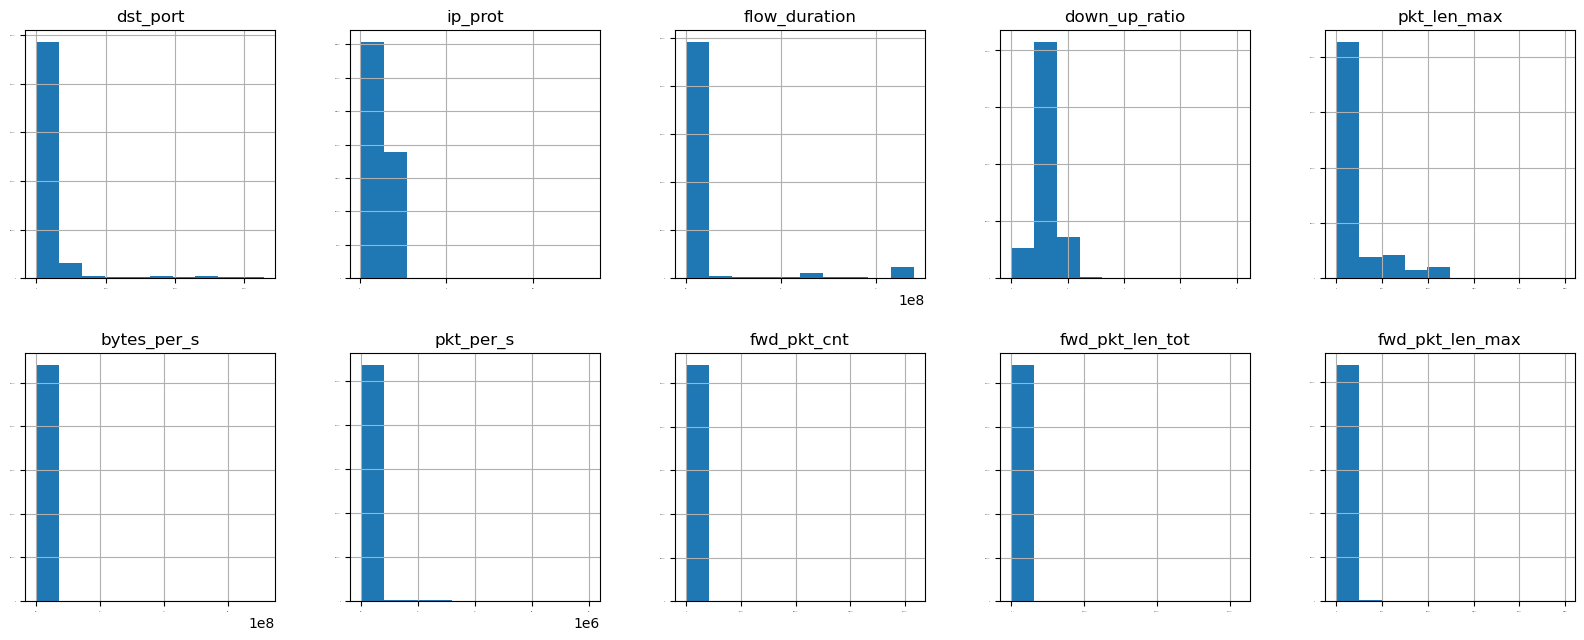

In [18]:
# histograms
df.hist(figsize=(20,20), layout=(5,5),sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

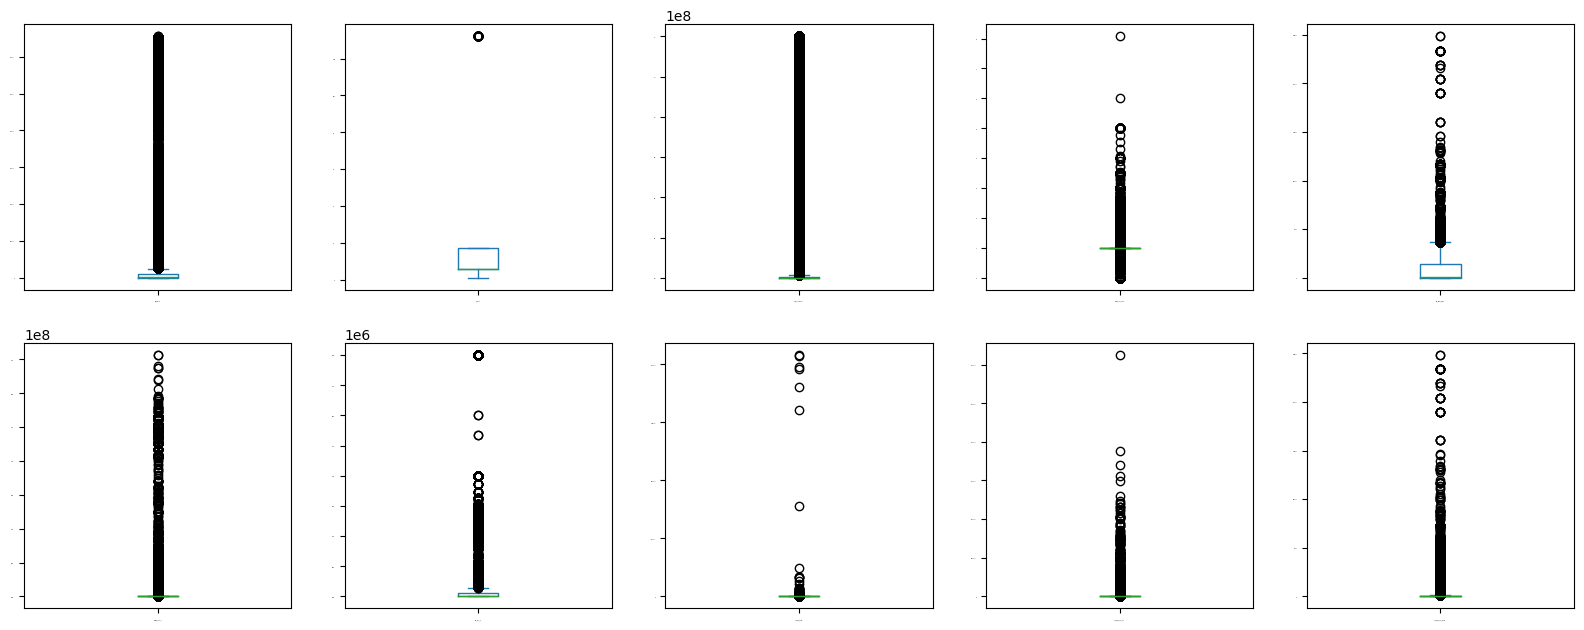

In [19]:
# box and whisker plots
df.plot(kind='box', subplots=True, figsize=(20,20), layout=(5,5), sharex=False, sharey=False,
fontsize=1)
plt.show()

# Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

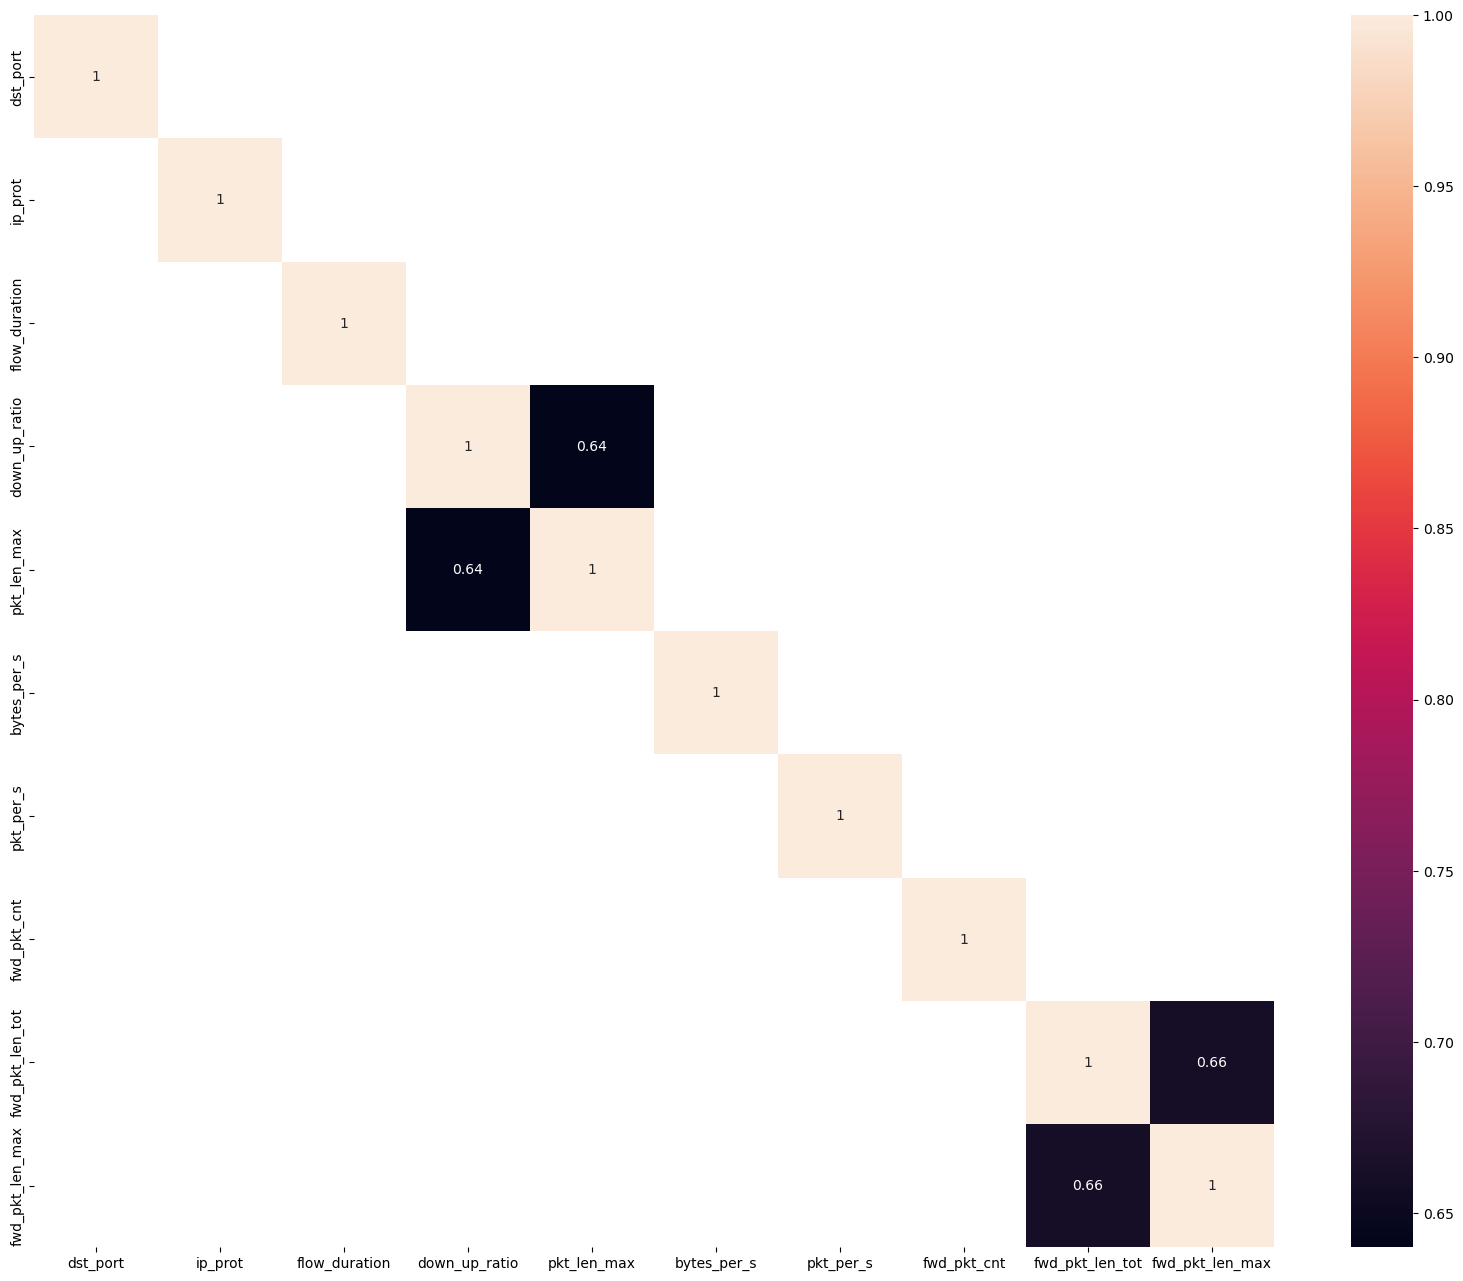

In [20]:
high_corr = df.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

# Machine Learning - Binary Classification

In [21]:
df.label[df.label == "benign"] = 0 # convert bonafide label to 0
df.label[df.label != 0] = 1 # convert attack labels to 1
df['label'].value_counts()

0    286438
1    256524
Name: label, dtype: int64

In [22]:
X = df.drop(columns = ["label"])
y = df.label
#X = X.astype(int) # convert to integers
y = y.astype(int)
print(X.shape, y.shape)

(542962, 10) (542962,)


# Spot checking DT, KNN and SVM models

In [23]:
# Test options and evaluation metric
num_folds = 10
seed = 42
shuffle = True
scoring = 'f1'
validation_size = 0.20

# Spot-Check Algorithms
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))

In [24]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
test_size=validation_size, random_state=seed)

In [35]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier().fit(X_train, Y_train)
dummy_preds = dummy_majority.predict(X_validation)
print("Dummy classifier test score: {:.2f}".format(dummy_majority.score(X_validation, Y_validation)))

Dummy classifier test score: 0.53


In [26]:
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train.values, Y_train.values, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


DT: 0.999917 (0.000040)
KNN: 0.998108 (0.000310)
SVM: 0.781147 (0.001656)


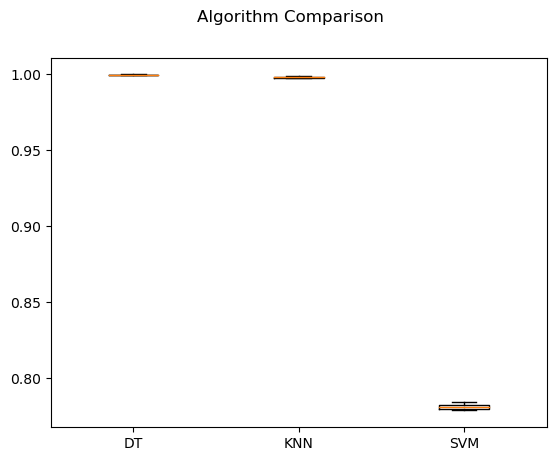

In [27]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [28]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN',KNeighborsClassifier())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

results = []
names = []
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train.values, Y_train.values, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledKNN: 0.999808 (0.000075)
ScaledDT: 0.999920 (0.000041)
ScaledSVM: 0.998522 (0.000162)


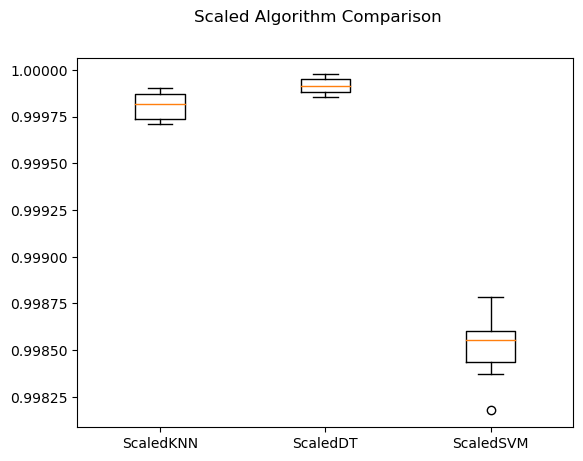

In [29]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [30]:
# hyperparameter tuning

algorithms = {
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
    "KNN" :(KNeighborsClassifier(), {
        "n_neighbors": [x for x in range(1,31)],
        "weights": ["uniform", "distance"]
        #"algorithm": ("ball_tree", "kd_tree", "brute"),
    #    "leaf_size": [x for x in range(28, 34)]
    }),
    #"SVM" :(SVC(random_state=seed, probability=True), [
    #    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": [0.1, 1, 10]},
    #    {"kernel": ["linear"], "C": [0.1, 1, 10]}
    #]),
}

# Randomized Search
## Reducing computational expense. The code of [1] is adapted to use RandomizedSearchCV for hyperparameter tuning

In [31]:
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed) # Train, Test
rskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) # Validation
perf = f1_score # can be used roc_auc_score for binary classification

score = {}
results = {}
for algorithm in algorithms.keys():
    score[algorithm] = []
    results[algorithm] = { 'expected': [], 'predicted': [] }

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = RandomizedSearchCV(clf, parameters, cv=rskf, scoring=make_scorer(perf), n_jobs=-1)
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))
        results[algorithm]['expected'].extend(y.iloc[test])
        results[algorithm]['predicted'].extend(best.predict_proba(prep.transform(X.iloc[test])).transpose()[1])
    print("Best parameters: {}".format(best.best_params_))
    print("Best cross-validation score: {:.2f}".format(best.best_score_))
    print("Best estimator:\n{}".format(best.best_estimator_))

DT
Best parameters: {'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best cross-validation score: 1.00
Best estimator:
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15)
KNN
Best parameters: {'weights': 'uniform', 'n_neighbors': 8}
Best cross-validation score: 1.00
Best estimator:
KNeighborsClassifier(n_neighbors=8)


In [32]:
# f1-scores
pd.DataFrame.from_dict(score)

,DT,KNN
0,0.999922,0.999883
1,0.999981,0.999922
2,0.999883,0.999844
3,0.999961,0.999864
4,0.999922,0.999883
5,0.999961,0.999825
6,0.999961,0.999903
7,0.999883,0.999786
8,0.999942,0.999825
9,0.999942,0.999864


## ROC/AUC evaluation

In [33]:
plt.style.use('plot_style.txt')

# ROC/AUC scores for the best set of parameters from the Grid Search above (for each k-fold)
for algorithm in algorithms.keys():
    roc_auc = roc_auc_score(results[algorithm]['expected'], results[algorithm]['predicted'])
    print('AUC(%s) = %.6f' % (algorithm, roc_auc))

AUC(DT) = 0.999941
AUC(KNN) = 0.999927


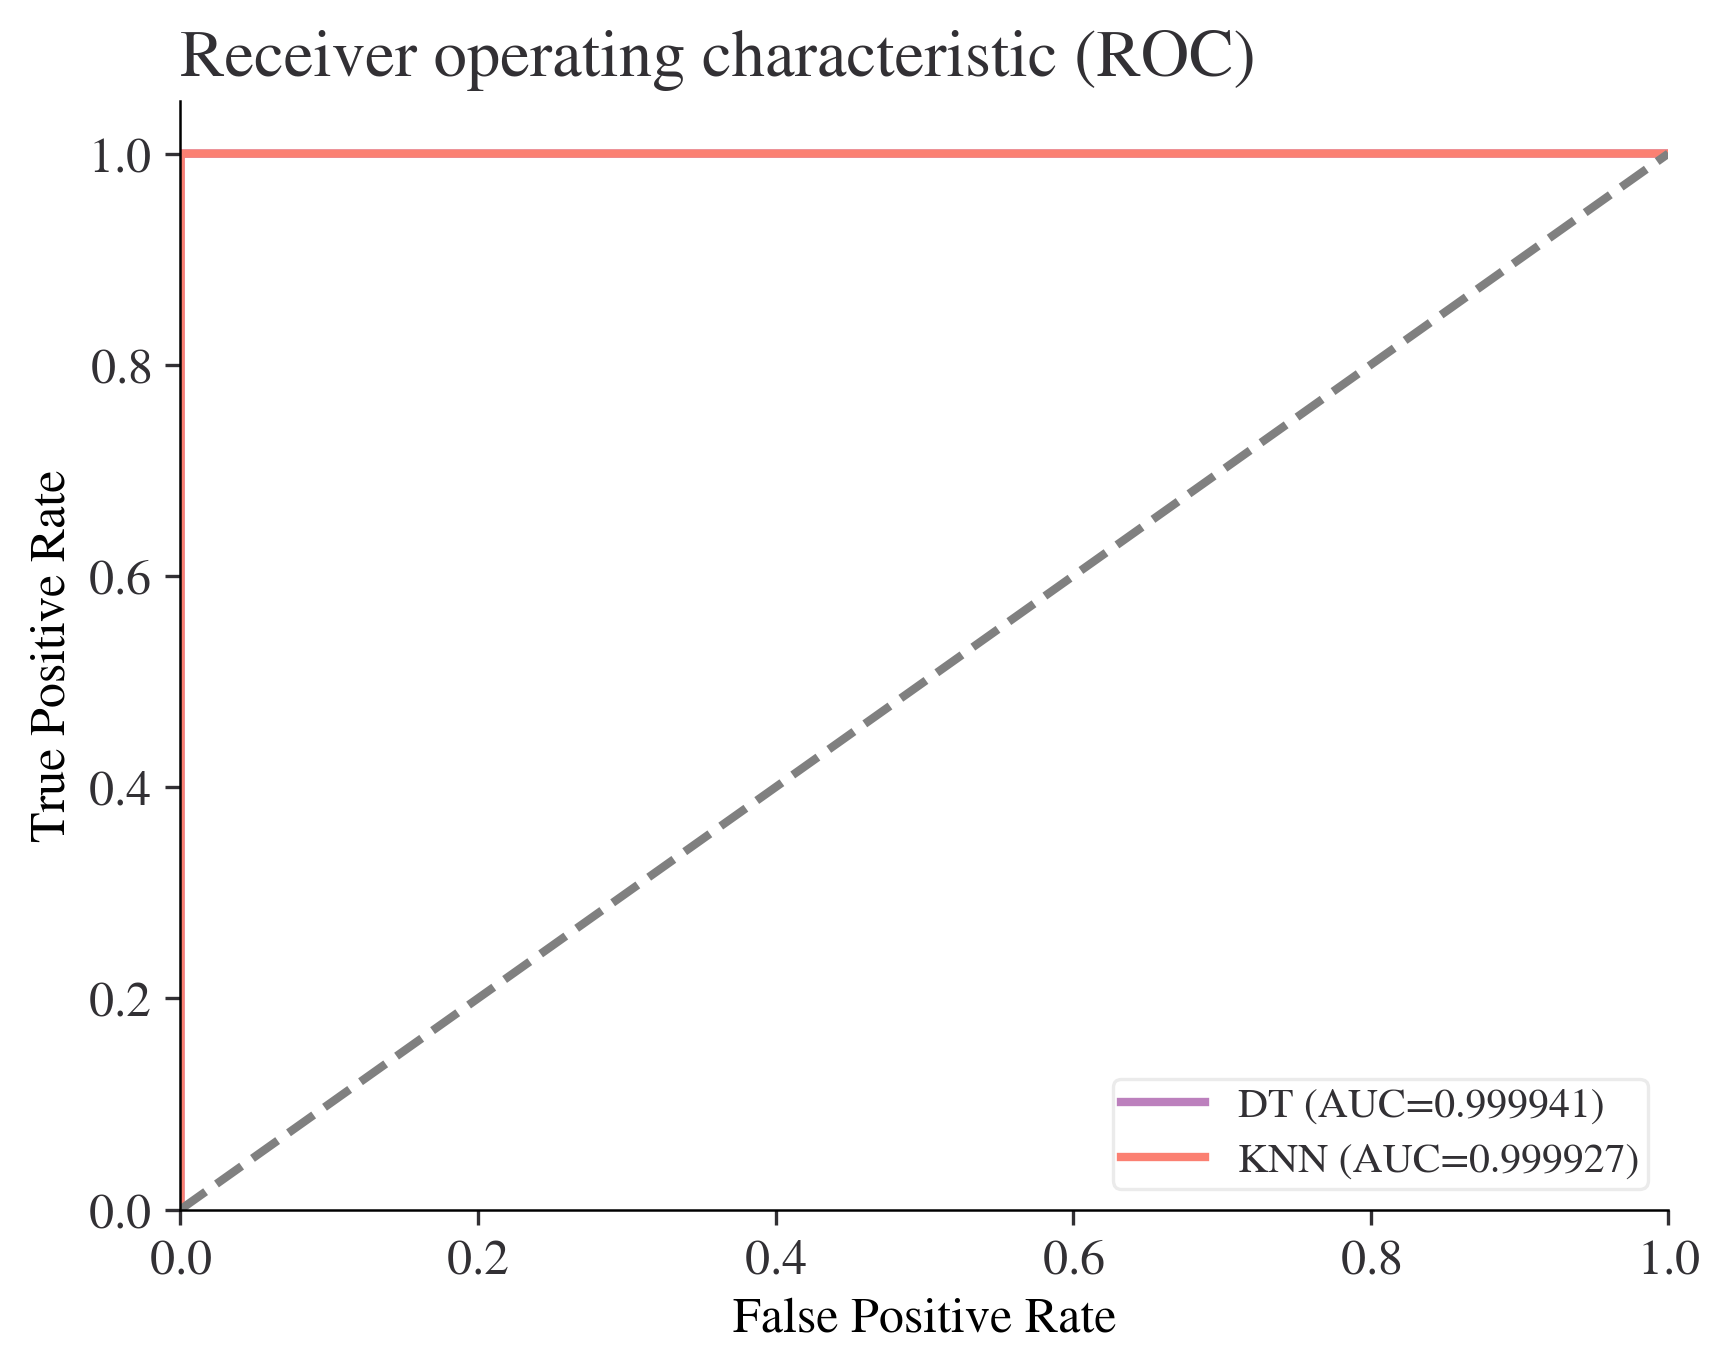

In [34]:
plt.figure()

index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = roc_curve(result['expected'], result['predicted'])
    AUC = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label="{} (AUC={:.6f})".format(model_key, AUC))
    index = index + 1
    # save ROC data
    #filename = 'data/LAN_'+model_key+'_ROC_data.csv'
    #pd.DataFrame.from_dict(data={ 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds }).to_csv(filename, index=False)
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")

#plt.savefig(os.path.join('images/', 'roc_lan_models.pdf'), dpi=300, bbox_inches="tight")

## Generate the models

### Prepare data - Pre-processing for ML

In [45]:
prep = StandardScaler()
prep.fit(X)

StandardScaler()

In [47]:
from joblib import dump
dump(prep, open('Models/preprocessor.pkl', 'wb'))

### Best estimators from Randomized Search CV

In [48]:
dt=DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=15)
knn=KNeighborsClassifier(n_neighbors=8)

In [49]:
dt.fit(X,y)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=8)

In [50]:
dump(dt, open('Models/dt.pkl', 'wb'))
dump(knn, open('Models/knn.pkl', 'wb'))

# References
>[1] G. De Carvalho Bertoli et al., “An End-to-End Framework for Machine Learning-Based Network Intrusion Detection System,” IEEE Access, vol. 9, pp. 106790–106805, 2021, doi: 10.1109/ACCESS.2021.3101188.\
>[2] A. Rosay, F. Carlier, E. Cheval, and P. Leroux, “From CIC-IDS2017 to LYCOS-IDS2017: A corrected dataset for better performance,” in IEEE/WIC/ACM International Conference on Web Intelligence, ESSENDON VIC Australia: ACM, Dec. 2021, pp. 570–575. doi: 10.1145/3486622.3493973.